# Covid19 Visualizer

In [1]:
%matplotlib notebook

In /home/duka/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/duka/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/duka/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### Colab instructions

- If you are running the notebook in Google Colab, make sure to uncomment the cell bellow and run it, so that it installs the necessary packages and fetches the necessary data. 

In [2]:
# !pip install mplcursors
# %mkdir data
# !gdown https://drive.google.com/uc?id=19b_TP8CKkBPoziiO8m5sVsKSTgmAk-kZ -O data/body_volume.npy
# !gdown https://drive.google.com/uc?id=1Y4v3vePcH6fqyBpdxWHkE1kFEca4BCmO -O data/hull_faces.npy
# !gdown https://drive.google.com/uc?id=1FmHEHaPmZnuHSBS-zOaYqc2ykl_ZP2pK -O data/covid_papers_data.json
# !gdown https://drive.google.com/uc?id=1ZgrGOcpminYDjgW32NHuS7RXey9LrlTi -O data/covid_papers_metadata.json

## Importing the necessary packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backend_bases import MouseButton
from mpl_toolkits.mplot3d import Axes3D, proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import ipywidgets as widgets
import mplcursors

## Loading the preparing the data

In [4]:
volume = np.load("data/body_volume.npy")
hull_faces = np.load("data/hull_faces.npy")
dimensions = list(volume.shape[:-1])

In [5]:
dframe_data = pd.read_json("data/covid_papers_data.json")
dframe_metadata = pd.read_json("data/covid_papers_metadata.json")

In [6]:
data = dframe_data.text_mapping.values
data = np.array([np.array(item) for item in data])
data = np.concatenate((data[:, 2][:, None], data[:, 0][:, None], data[:, 1][:, None]), axis=1)
data = np.clip(data, np.array([0.0, 0.0, 0.0]), np.array(dimensions) - 1.0)

## Interactive plots

In [7]:
def create_crosshair(point):
    global ax1
    
    ax1.plot(point[0] * np.ones(25), 
             point[1] * np.ones(25), 
             np.arange(point[2]-12, point[2]+13),
             c='lime',
             linewidth=2,
             picker=False)
    ax1.plot(point[0] * np.ones(25),
             np.arange(point[1]-12, point[1]+13),
             point[2] * np.ones(25),
             c='lime',
             linewidth=2,
             picker=False)
    ax1.plot(np.arange(point[0]-12, point[0]+13),
             point[1] * np.ones(25),
             point[2] * np.ones(25), 
             c='lime',
             linewidth=2,
             picker=False)



def update_crosshair(point):
    global ax1
    
    ax1.lines[0].set_data(point[0] * np.ones(25), point[1] * np.ones(25))
    ax1.lines[0].set_3d_properties(np.arange(point[2]-12, point[2]+13))
    
    ax1.lines[1].set_data(point[0] * np.ones(25), np.arange(point[1]-12, point[1]+13))
    ax1.lines[1].set_3d_properties(point[2] * np.ones(25))
    
    ax1.lines[2].set_data(np.arange(point[0]-12, point[0]+13), point[1] * np.ones(25))
    ax1.lines[2].set_3d_properties(point[2] * np.ones(25))
    
    
def return_closest_data_indices(point, top_K):
    distances = np.linalg.norm(np.array(point) - np.array(data), ord=2, axis=1)
    return np.argpartition(distances, top_K)[:top_K]


def onclick(event):
    global point
    global display_data
    
    if event.button != MouseButton.LEFT:
        return
    
    if event.inaxes == ax2:   
        
        point[0] = volume.shape[0] - event.ydata
        point[2] = event.xdata
        
        horiz2.set_ydata(event.ydata)
        vert2.set_xdata(event.xdata)
        
        horiz3.set_ydata(event.ydata)
        ax3.index = int(event.xdata)
        ax3.images[0].set_array(volume[:, :, ax3.index])
        
        vert4.set_xdata(event.xdata)
        ax4.index = int(event.ydata)
        ax4.images[0].set_array(volume[ax4.index, :, :])
        
    elif event.inaxes == ax3:
        
        point[0] = volume.shape[0] - event.ydata
        point[1] = event.xdata
        
        horiz3.set_ydata(event.ydata)
        vert3.set_xdata(event.xdata)
        
        horiz2.set_ydata(event.ydata)
        ax2.index = int(event.xdata)
        ax2.images[0].set_array(volume[:, ax2.index, :])
        
        horiz4.set_ydata(event.xdata)
        ax4.index = int(event.ydata)
        ax4.images[0].set_array(volume[ax4.index, :, :])
        
    elif event.inaxes == ax4:
        
        point[1] = event.ydata
        point[2] = event.xdata
        
        horiz4.set_ydata(event.ydata)
        vert4.set_xdata(event.xdata)
        
        vert2.set_xdata(event.xdata)
        ax2.index = int(event.ydata)
        ax2.images[0].set_array(volume[:, ax2.index, :])
        
        vert3.set_xdata(event.ydata)
        ax3.index = int(event.xdata)
        ax3.images[0].set_array(volume[:, :, ax3.index])
        
    else:
        return
    
    ax5.cla()
    ax5.text(0.15, 0.35, f" x: {point[1]:.2f}\n y: {point[2]:.2f}\n z: {point[0]:.2f}", 
             bbox=dict(facecolor='lime', alpha=0.5))
    ax5.axis('off')
    
    ind = np.argmin(np.square(np.array(point) - data).sum(axis=1))
    closest_indices = return_closest_data_indices(np.array(point), top_K = 200)
    display_data = data[closest_indices, :]
    
    ax1.cla()
    sc = ax1.scatter(display_data[:, 1], 
                     display_data[:, 2], 
                     display_data[:, 0], 
                     picker=True, 
                     alpha=0.5)
    ax1.add_collection3d(Poly3DCollection(hull_faces, alpha=0.02, color='blue', edgecolor='white'))
    create_crosshair([point[1], point[2], point[0]])
    ax1.set_xlim((0, volume.shape[1]))
    ax1.set_ylim((0, volume.shape[2]))
    ax1.set_zlim((0, volume.shape[0]))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])

    
    paper_id = dframe_data.iloc[ind]['paper_id']
    title_box.value = dframe_data.iloc[ind]['title']
    author_box.value = dframe_data.iloc[ind]['author']
    abstract_box.value = dframe_data.iloc[ind]['abstract']
    author = dframe_metadata[dframe_metadata['sha'] == paper_id]['authors'].item()
    if author:
        author = ",  ".join(author.split("'")[1::2])
    author_box.value = author
    year_box.value = dframe_metadata[dframe_metadata['sha'] == paper_id]['publish_time'].item()
    pid_box.value = paper_id
    doi_box.value = dframe_metadata[dframe_metadata['sha'] == paper_id]['doi'].item()
    
    
def onpick(event):
    global point
    global display_data
    
    koki = event
    
    ind = event.ind[0]
    point = display_data[ind]

    ax2.index = int(point[1])
    ax2.images[0].set_array(volume[:, ax2.index, :])
    horiz2.set_ydata(volume.shape[0] - point[0])
    vert2.set_xdata(point[2])

    ax3.index = int(point[2])
    ax3.images[0].set_array(volume[:, :, ax3.index])
    horiz3.set_ydata(volume.shape[0] - point[0])
    vert3.set_xdata(point[1])

    ax4.index = int(volume.shape[0] - point[0])
    ax4.index = max(0, min(ax4.index, volume.shape[0] - 1))
    ax4.images[0].set_array(volume[ax4.index, :, :])
    horiz4.set_ydata(point[1])
    vert4.set_xdata(point[2])
    
    ax5.cla()
    ax5.text(0.15, 0.35, f" x: {point[1]:.2f}\n y: {point[2]:.2f}\n z: {point[0]:.2f}", 
             bbox=dict(facecolor='lime', alpha=0.5))
    ax5.axis('off')
    
    update_crosshair([point[1], point[2], point[0]])
    
    paper_id = dframe_data.iloc[ind]['paper_id']
    title_box.value = dframe_data.iloc[ind]['title']
    author_box.value = dframe_data.iloc[ind]['author']
    abstract_box.value = dframe_data.iloc[ind]['abstract']
    author = dframe_metadata[dframe_metadata['sha'] == paper_id]['authors'].item()
    if author:
        author = ",  ".join(author.split("'")[1::2])
    author_box.value = author
    year_box.value = dframe_metadata[dframe_metadata['sha'] == paper_id]['publish_time'].item()
    pid_box.value = paper_id
    doi_box.value = dframe_metadata[dframe_metadata['sha'] == paper_id]['doi'].item()

<IPython.core.display.Javascript object>


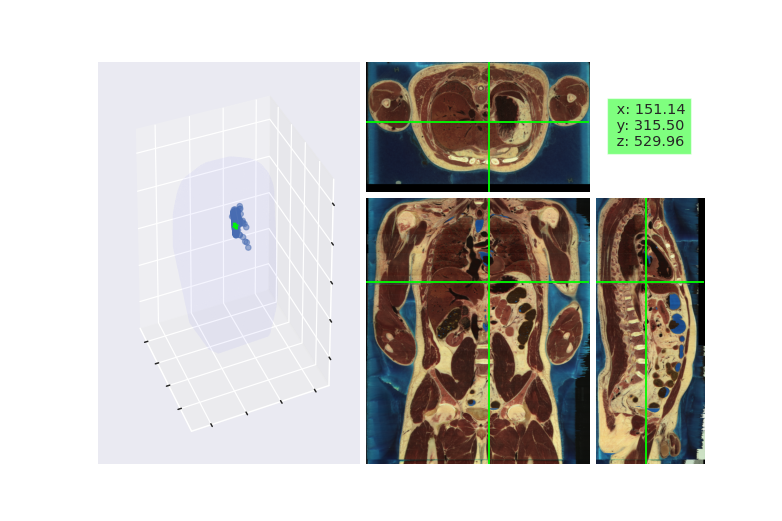

GridBox(children=(HTML(value='', description='Title:'), HTML(value='', description='Authors:'), HTML(value='',…

In [8]:
point = [volume.shape[0] // 2, volume.shape[1] // 2, volume.shape[2] // 2]
display_data = data[return_closest_data_indices(np.array(point), top_K=200)]

title_box = widgets.HTML(
    value="",
    description="Title:"
)

author_box = widgets.HTML(
    value="",
    description="Authors:"
)

year_box = widgets.HTML(
    value="",
    description="Date:"
)

doi_box = widgets.HTML(
    value="",
    description="DOI:",
)

pid_box = widgets.HTML(
    value="",
    description="ID:",
)

abstract_box = widgets.HTML(
    value="",
    description="Abstract:",
)
    
    
sns.set()

fig = plt.figure(figsize = (9, 6))
grid = plt.GridSpec(12, 16, hspace=0.2, wspace=0.2)

ax1 = fig.add_subplot(grid[:, :7], projection='3d')
sc = ax1.scatter(display_data[:, 1], display_data[:, 2], display_data[:, 0], picker=True, alpha=0.5)
ax1.add_collection3d(Poly3DCollection(hull_faces, alpha=0.02, color='blue', edgecolor='white'))
create_crosshair([volume.shape[1] // 2, volume.shape[2] // 2, volume.shape[0] // 2])
ax1.set_xlim((0, volume.shape[1]))
ax1.set_ylim((0, volume.shape[2]))
ax1.set_zlim((0, volume.shape[0]))
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])
cursor = mplcursors.cursor(ax1, highlight=False)   
@cursor.connect("add")
def _(sel):
    sel.annotation.set(text="", bbox=None)
    sel.annotation.arrow_patch.set(alpha=0.0)


ax2 = fig.add_subplot(grid[4:, 7:13])
ax2.index = volume.shape[1] // 2
ax2.imshow(volume[:, ax2.index, :], aspect="auto")
horiz2 = ax2.axhline(volume.shape[0] // 2, color='lime')
vert2 = ax2.axvline(volume.shape[2] // 2, color='lime')
ax2.axis('off')

ax3 = fig.add_subplot(grid[4:, 13:])
ax3.index = volume.shape[2] // 2
ax3.imshow(volume[:, :, ax3.index], aspect="auto")
horiz3 = ax3.axhline(volume.shape[0] // 2, color='lime')
vert3 = ax3.axvline(volume.shape[1] // 2, color='lime')
ax3.axis('off')

ax4 = fig.add_subplot(grid[:4, 7:13])
ax4.index = volume.shape[0] // 2
ax4.imshow(volume[ax4.index, :, :], aspect="auto")
horiz4 = ax4.axhline(volume.shape[1] // 2, color='lime')
vert4 = ax4.axvline(volume.shape[2] // 2, color='lime')
ax4.axis('off')

ax5 = fig.add_subplot(grid[:4, 13:])
ax5.text(0.15, 0.35, f" x: {point[1]:.2f}\n y: {point[2]:.2f}\n z: {point[0]:.2f}",
         bbox=dict(facecolor='lime', alpha=0.5))
ax5.axis('off')

fig.canvas.mpl_connect('pick_event', onpick)
fig.canvas.mpl_connect('button_press_event', onclick)
    
widget_box = widgets.GridBox(children=[title_box, author_box, year_box, pid_box, doi_box, abstract_box],
        layout=widgets.Layout(
            width='100%',
            grid_template_rows='10% 10% 10% 10% 10% 50%',
            grid_template_columns='100%',
            grid_template_areas='''
            "title_box"
            "author_box"
            "year_box"
            "pid_box"
            "doi_box"
            "abstract_box"
            ''')
       )

widget_box